## 네이버 영화리뷰 감성분석

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.3.3


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### Data loader
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [4]:
copied_data = train_data.copy()
copied_data[copied_data.duplicated()]

,id,document,label


In [5]:
copied_data[copied_data.isna( ).any(axis=1)]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [6]:
"""
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
"""
def preprocess(data):
    # 데이터의 중복 제거
    data = data.drop_duplicates()
    # NaN 결측치 제거
    data = data.dropna()
    
    tokenized=[]
    for sentence in data['document']:
        # 토큰화
        temp = tokenizer.morphs(sentence)
        # 불용어 제거
        temp = [word for word in temp if not word in stopwords]
        tokenized.append(temp)
        
    return tokenized

In [7]:
processed = preprocess(copied_data)
processed

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠',
  '.',
  '..',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '.',
  '...',
  '오버',
  '연기',
  '조차',
  '가볍',
  '지',
  '않',
  '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정'],
 ['사이몬페그',
  '익살',
  '스런',
  '연기',
  '돋보였',
  '던',
  '영화',
  '!',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '너무나',
  '이뻐',
  '보였',
  '다'],
 ['막',
  '걸음마',
  '뗀',
  '3',
  '세',
  '부터',
  '초등',
  '학교',
  '1',
  '학년',
  '생',
  '인',
  '8',
  '살',
  '용',
  '영화',
  '.',
  'ㅋㅋㅋ',
  '.',
  '..',
  '별반',
  '개',
  '아까움',
  '.'],
 ['원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다', '.'],
 ['별',
  '반개',
  '아깝',
  '다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '몇',
  '년',
  '인지',
  '.',
  '.',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫',
  '겟',
  '다',
  '납치',
  '.',
  '감금',
  '만',
  '반복',
  '반복',
  '.',
  '.',
  '드라마',
  '가족',
  '없',
  '다

In [8]:
"""
- 사전word_to_index 구성
"""
def build_vocabulary(tokenized_texts, num_words=None):
    all_words = [word for text in tokenized_texts for word in text]
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(num_words)
    
    word_to_index = {
        '<PAD>': 0,   # 패딩용 단어
        '<BOS>': 1,   # 문장의 시작지점
        '<UNK>': 2,   # 사전에 없는(Unknown) 단어
        '<UNUSED>': 3 # 사용하지 않는 단어
    }
    
    # 단어 추가
    for i, (word, _) in enumerate(most_common_words, start=len(word_to_index)):
        word_to_index[word] = i
    
    return word_to_index

In [9]:
dictionary = build_vocabulary(processed)
dictionary

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '점': 36,
 '같': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '최고': 54,
 '주': 55,
 '내': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '어요': 60,
 '던': 61,
 '할': 62,
 '왜': 63,
 '1': 64,
 '겠': 65,
 '해': 66,
 '스토리': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '감동': 79,
 '때': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '볼': 86,
 '알': 87,
 '만들': 88,
 '내용': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '재미': 93,
 '그냥': 94,
 '지

In [10]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index.get(word, word_to_index['<UNK>']) for word in sentence_tokens]

def get_encoded_sentences(sentences, word_to_index):
    return [[word_to_index.get(word, word_to_index['<UNK>']) for word in text] for text in sentences]

In [11]:
encoded = get_encoded_sentences(processed, dictionary)
encoded

[[32, 74, 921, 4, 4, 39, 230, 20, 33, 752],
 [1022, 4, 11, 520, 549, 686, 5, 120, 4, 70, 1643, 52, 926, 1010, 15, 44, 391],
 [24, 205, 30124],
 [8428, 159, 3935, 4, 4, 298, 93, 17, 6, 4, 4, 58, 3485],
 [22689,
  8913,
  1108,
  52,
  2839,
  61,
  5,
  14,
  2766,
  41,
  1193,
  35,
  352,
  42,
  22,
  40,
  61,
  16075,
  22690,
  429,
  3104,
  1771,
  6],
 [676,
  22691,
  18671,
  131,
  420,
  185,
  1554,
  715,
  64,
  1699,
  706,
  53,
  376,
  193,
  268,
  5,
  4,
  69,
  4,
  11,
  2164,
  122,
  743,
  4],
 [255, 382, 9, 385, 2013, 56, 15, 819, 6, 4],
 [235,
  1458,
  141,
  6,
  426,
  756,
  10866,
  16076,
  52,
  1537,
  290,
  99,
  252,
  4,
  4,
  28,
  857,
  29,
  353,
  655,
  542,
  509,
  585,
  6,
  3327,
  4,
  8914,
  22,
  1463,
  1463,
  4,
  4,
  71,
  304,
  17,
  6,
  52,
  106,
  8,
  77,
  22,
  30125,
  43],
 [129, 17, 23, 93, 16, 290, 27, 48, 5],
 [63,
  658,
  58,
  241,
  764,
  18,
  574,
  86,
  10079,
  4,
  4,
  1487,
  637,
  739,
  81,
  2

In [12]:
target = copied_data['label']
target

0         0
1         1
2         0
3         0
4         1
         ..
149995    0
149996    1
149997    0
149998    1
149999    0
Name: label, Length: 150000, dtype: int64

In [13]:
"""
1. 전처리
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
2. 어휘 사전 만들기
- 사전 word_to_index 구성
3. 인코딩
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
4. 타겟 값 추출
- X_train, y_train, X_test, y_test, word_to_index 리턴
"""
def my_load_data(train_data, test_data, num_words=10000):
    # 1. 전처리
    train_tokenized = preprocess(train_data)
    test_tokenized = preprocess(test_data)
    
    # 2. 어휘 사전 만들기
    word_to_index = build_vocabulary(train_tokenized)
    
    # 3. 인코딩
    X_train = get_encoded_sentences(train_tokenized, word_to_index)
    X_test = get_encoded_sentences(train_tokenized, word_to_index)
    
    # 4. 타겟 값 추출
    y_train = train_data['label']
    y_test = test_data['label']
    
    return X_train, y_train, X_test, y_test, word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = my_load_data(train_data, test_data)

In [14]:
X_train, y_train, X_test, y_test, word_to_index

([[32, 74, 921, 4, 4, 39, 230, 20, 33, 752],
  [1022,
   4,
   11,
   520,
   549,
   686,
   5,
   120,
   4,
   70,
   1643,
   52,
   926,
   1010,
   15,
   44,
   391],
  [24, 205, 30124],
  [8428, 159, 3935, 4, 4, 298, 93, 17, 6, 4, 4, 58, 3485],
  [22689,
   8913,
   1108,
   52,
   2839,
   61,
   5,
   14,
   2766,
   41,
   1193,
   35,
   352,
   42,
   22,
   40,
   61,
   16075,
   22690,
   429,
   3104,
   1771,
   6],
  [676,
   22691,
   18671,
   131,
   420,
   185,
   1554,
   715,
   64,
   1699,
   706,
   53,
   376,
   193,
   268,
   5,
   4,
   69,
   4,
   11,
   2164,
   122,
   743,
   4],
  [255, 382, 9, 385, 2013, 56, 15, 819, 6, 4],
  [235,
   1458,
   141,
   6,
   426,
   756,
   10866,
   16076,
   52,
   1537,
   290,
   99,
   252,
   4,
   4,
   28,
   857,
   29,
   353,
   655,
   542,
   509,
   585,
   6,
   3327,
   4,
   8914,
   22,
   1463,
   1463,
   4,
   4,
   71,
   304,
   17,
   6,
   52,
   106,
   8,
   77,
   22,
   30125,
   43],

In [15]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [16]:
X_train, y_train, X_test, y_test, word_to_index

([[31, 73, 918, 3, 3, 38, 227, 19, 32, 747],
  [1027,
   3,
   10,
   518,
   548,
   686,
   4,
   119,
   3,
   69,
   1638,
   51,
   924,
   1005,
   14,
   43,
   390],
  [23, 204, 2],
  [8408, 157, 3924, 3, 3, 297, 93, 16, 5, 3, 3, 57, 3478],
  [2,
   8893,
   1107,
   51,
   2831,
   59,
   4,
   13,
   2757,
   40,
   1187,
   34,
   350,
   41,
   21,
   39,
   59,
   2,
   2,
   426,
   3101,
   1765,
   5],
  [674,
   2,
   2,
   130,
   419,
   184,
   1546,
   711,
   64,
   1693,
   714,
   52,
   374,
   191,
   270,
   4,
   3,
   68,
   3,
   10,
   2178,
   121,
   749,
   3],
  [252, 380, 8, 383, 2011, 54, 14, 816, 5, 3],
  [231,
   1449,
   143,
   5,
   424,
   755,
   2,
   2,
   51,
   1531,
   289,
   98,
   249,
   3,
   3,
   27,
   854,
   28,
   352,
   651,
   539,
   508,
   582,
   5,
   3317,
   3,
   8894,
   21,
   1459,
   1459,
   3,
   3,
   70,
   303,
   16,
   5,
   51,
   103,
   7,
   76,
   21,
   2,
   42],
  [127, 16, 22, 93, 15, 289, 26, 47

In [17]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [18]:
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '.',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '..',
 11: '게',
 12: ',',
 13: '!',
 14: '지',
 15: '있',
 16: '없',
 17: '?',
 18: '좋',
 19: '나',
 20: '었',
 21: '만',
 22: '는데',
 23: '너무',
 24: '봤',
 25: '적',
 26: '안',
 27: '정말',
 28: '로',
 29: '음',
 30: '것',
 31: '아',
 32: '네요',
 33: '재밌',
 34: '어',
 35: '같',
 36: '점',
 37: '지만',
 38: '진짜',
 39: '했',
 40: '에서',
 41: '기',
 42: '네',
 43: '않',
 44: '거',
 45: '았',
 46: '수',
 47: '되',
 48: '면',
 49: 'ㅋㅋ',
 50: '말',
 51: '연기',
 52: '인',
 53: '주',
 54: '내',
 55: '최고',
 56: '~',
 57: '평점',
 58: '이런',
 59: '던',
 60: '어요',
 61: '할',
 62: '왜',
 63: '겠',
 64: '1',
 65: '스토리',
 66: '해',
 67: '습니다',
 68: 'ㅋㅋㅋ',
 69: '...',
 70: '드라마',
 71: '생각',
 72: '아니',
 73: '더',
 74: '그',
 75: '싶',
 76: '사람',
 77: '듯',
 78: '때',
 79: '감동',
 80: '함',
 81: '배우',
 82: '본',
 83: '까지',
 84: '뭐',
 85: '알',
 86: '만들',
 87: '내용',
 88: '볼',
 89: '감독',
 90: '보다',
 91: '라',
 92: '그냥',
 93: '재미',
 94: '시간',
 95: '지루'

#### 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- `keras.preprocessing.sequence.pad_sequences` 을 활용한 패딩 추가

In [19]:
# X_train과 X_test에 있는 텍스트 시퀀스들의 길이를 tokens_len에 리스트로 저장
tokens_len = [len(tokens) for tokens in X_train + X_test]

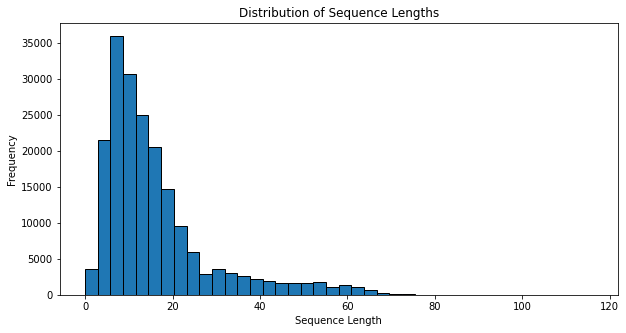

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(tokens_len, bins=40, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [21]:
# 상위 95% 문장의 길이
max_len = int(np.percentile(tokens_len, 95))
max_len

47

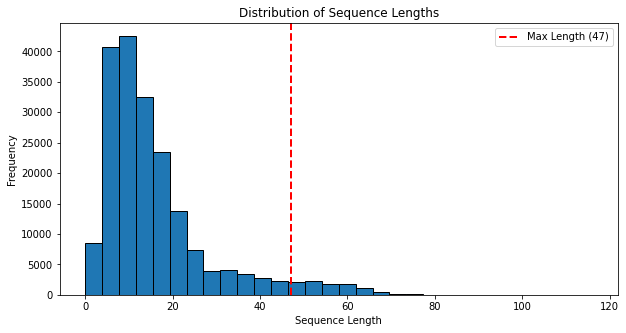

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(tokens_len, bins=30, edgecolor='black')  
plt.axvline(max_len, color='red', linestyle='dashed', linewidth=2, label=f'Max Length ({max_len})')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()
plt.show()

In [23]:
import numpy as np
import tensorflow as tf
import os

X_train_pre_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                                   value=word_to_index['<PAD>'],
                                                                   padding='pre',
                                                                   maxlen=max_len)

X_test_pre_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                                  value=word_to_index['<PAD>'],
                                                                  padding='pre',
                                                                  maxlen=max_len)

In [24]:
X_train_pre_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  31,  73,
       918,   3,   3,  38, 227,  19,  32, 747], dtype=int32)

### 모델 구성 및 validation set 구성
- LSTM
- CNN
- Bi-LSTM

### validation set 구성

In [25]:
from sklearn.model_selection import train_test_split

# 훈련 데이터에서 20%를 검증 데이터로 분리
X_train_pre, X_val_pre, y_train_final, y_val = train_test_split(
    X_train_pre_padded, y_train, test_size=0.2, random_state=42
)

X_train_pre.shape, X_val_pre.shape

((116945, 47), (29237, 47))

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [27]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200

#### LSTM

In [28]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    LSTM(8, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         1999800   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,569
Trainable params: 2,006,569
Non-trainable params: 0
_________________________________________________________________


#### CNN

In [29]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [30]:
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    Conv1D(16, kernel_size=5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(16, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         1999800   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          16016     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### Bi-LSTM

In [31]:
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    Bidirectional(LSTM(8, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         1999800   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 16)          13376     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,013,321
Trainable params: 2,013,321
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [32]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [33]:
batch_size = 512
epochs = 10

In [34]:
X_test_pre_padded, y_test

(array([[   0,    0,    0, ...,    0,  831,  129],
        [   0,    0,    0, ...,    0,    0,    2],
        [   0,    0,    0, ..., 3556,   72,  916],
        ...,
        [   0,    0,    0, ...,    7,   11, 3423],
        [   0,    0,    0, ...,   66,  322,   42],
        [   0,    0,    0, ...,  178,   62, 1057]], dtype=int32),
 array([1, 0, 0, ..., 0, 0, 0]))

In [35]:
history_lstm_pre = model_lstm.fit(X_train_pre,
                              y_train_final,
                              validation_data=(X_val_pre, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              callbacks=[early_stopping])

history_cnn_pre = model_cnn.fit(X_train_pre,
                            y_train_final,
                            validation_data=(X_val_pre, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping])

history_bilstm_pre = model_bilstm.fit(X_train_pre,
                                  y_train_final,
                                  validation_data=(X_val_pre, y_val),
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  callbacks=[early_stopping])

Epoch 1/10
229/229 [==============================] - 6s 11ms/step - loss: 0.4588 - accuracy: 0.7974 - val_loss: 0.3614 - val_accuracy: 0.8452
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3229 - accuracy: 0.8648 - val_loss: 0.3438 - val_accuracy: 0.8525
Epoch 3/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2891 - accuracy: 0.8807 - val_loss: 0.3480 - val_accuracy: 0.8511
Epoch 4/10
229/229 [==============================] - 1s 7ms/step - loss: 0.2651 - accuracy: 0.8911 - val_loss: 0.3546 - val_accuracy: 0.8535
Epoch 5/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2442 - accuracy: 0.9008 - val_loss: 0.3676 - val_accuracy: 0.8522
Epoch 6/10
229/229 [==============================] - 1s 7ms/step - loss: 0.2257 - accuracy: 0.9092 - val_loss: 0.3813 - val_accuracy: 0.8502
Epoch 7/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2077 - accuracy: 0.9181 - val_loss: 0.3986 - val_accuracy: 0.8475
Epoch

In [36]:
results_lstm_pre = model_lstm.evaluate(X_test_pre_padded,  y_test, verbose=2)  # (loss, accuracy)
results_cnn_pre = model_cnn.evaluate(X_test_pre_padded,  y_test, verbose=2)  # (loss, accuracy)
results_bilstm_pre = model_bilstm.evaluate(X_test_pre_padded,  y_test, verbose=2)  # (loss, accuracy)

1537/1537 - 3s - loss: 0.3972 - accuracy: 0.8475
1537/1537 - 3s - loss: 0.7588 - accuracy: 0.7727
1537/1537 - 4s - loss: 0.3963 - accuracy: 0.8493


In [37]:
print(f'LSTM    | Loss {results_lstm_pre[0]} | Accuracy {results_lstm_pre[1]}')
print(f'CNN     | Loss {results_cnn_pre[0]} | Accuracy {results_cnn_pre[1]}')
print(f'Bi-LSTM | Loss {results_bilstm_pre[0]}  | Accuracy {results_bilstm_pre[1]}')

LSTM    | Loss 0.39719629287719727 | Accuracy 0.8475090265274048
CNN     | Loss 0.7588464021682739 | Accuracy 0.7727078795433044
Bi-LSTM | Loss 0.39625510573387146  | Accuracy 0.8493398427963257


### Loss, Accuracy 그래프 시각화

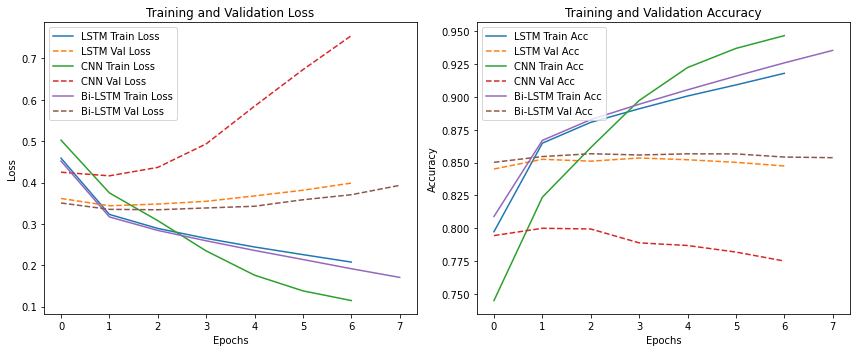

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history_lstm_pre.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm_pre.history['val_loss'], label='LSTM Val Loss', linestyle='dashed')
plt.plot(history_cnn_pre.history['loss'], label='CNN Train Loss')
plt.plot(history_cnn_pre.history['val_loss'], label='CNN Val Loss', linestyle='dashed')
plt.plot(history_bilstm_pre.history['loss'], label='Bi-LSTM Train Loss')
plt.plot(history_bilstm_pre.history['val_loss'], label='Bi-LSTM Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history_lstm_pre.history['accuracy'], label='LSTM Train Acc')
plt.plot(history_lstm_pre.history['val_accuracy'], label='LSTM Val Acc', linestyle='dashed')
plt.plot(history_cnn_pre.history['accuracy'], label='CNN Train Acc')
plt.plot(history_cnn_pre.history['val_accuracy'], label='CNN Val Acc', linestyle='dashed')
plt.plot(history_bilstm_pre.history['accuracy'], label='Bi-LSTM Train Acc')
plt.plot(history_bilstm_pre.history['val_accuracy'], label='Bi-LSTM Val Acc', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

**그래프 분석**  
- LSTM과 Bi-LSTM은 크게 성능 차이가 없는 것으로 보임
- 1D CNN은 빠르게 수렴하는 것 같지만 검증 성능이 떨어짐

### 학습된 Embedding 레이어 분석

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

임베딩 레이어 저장해서 벡터 확인해보자

In [40]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(9999, 200)


In [41]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(9999, 200)


In [42]:
embedding_layer = model_bilstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

word2vec_file_path_bilstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_bilstm.txt'
f = open(word2vec_file_path_bilstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_bilstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(9999, 200)


In [43]:
word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

In [44]:
word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

In [45]:
word_vectors_bilstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_bilstm, binary=False)

유사도 확인

In [46]:
word_vectors_lstm.similar_by_word("재미")

[('넘', 0.7503796815872192),
 ('이리', 0.7283036708831787),
 ('이렇게', 0.6835592985153198),
 ('완전', 0.6812553405761719),
 ('존재감', 0.671144425868988),
 ('너무', 0.6625476479530334),
 ('열라', 0.6498345732688904),
 ('항상', 0.6369944214820862),
 ('지극히', 0.6301668286323547),
 ('집중', 0.6250428557395935)]

In [47]:
word_vectors_cnn.similar_by_word("재미")

[('잖아', 0.4759911298751831),
 ('일까', 0.4712154269218445),
 ('미묘', 0.4411381483078003),
 ('컨텐츠', 0.437041312456131),
 ('상황', 0.4282914102077484),
 ('극본', 0.42640501260757446),
 ('140', 0.4220183789730072),
 ('총싸움', 0.4213392436504364),
 ('르', 0.42025303840637207),
 ('리언', 0.4193178117275238)]

In [48]:
word_vectors_bilstm.similar_by_word("재미")

[('겁나', 0.7022676467895508),
 ('원작자', 0.698462963104248),
 ('조진웅', 0.6687362194061279),
 ('회차', 0.6544288396835327),
 ('일으키', 0.654002845287323),
 ('태어난', 0.6503100991249084),
 ('던지', 0.6495126485824585),
 ('아이고', 0.6486409902572632),
 ('부려', 0.6468275189399719),
 ('가치', 0.6463761329650879)]

In [49]:
word_vectors_lstm.similar_by_word("실망")

[('별로', 0.9552515149116516),
 ('제로', 0.9332622289657593),
 ('졸작', 0.930243968963623),
 ('재미없', 0.9283674359321594),
 ('비추', 0.9224492311477661),
 ('억지', 0.9186102151870728),
 ('쓰레기', 0.9113249182701111),
 ('지루함', 0.9110241532325745),
 ('개뿔', 0.899741530418396),
 ('실패', 0.8928592205047607)]

In [50]:
word_vectors_cnn.similar_by_word("실망")

[('생긴', 0.665562629699707),
 ('찝찝', 0.6554356217384338),
 ('노', 0.6387472152709961),
 ('포장', 0.6327338814735413),
 ('돈', 0.5958315134048462),
 ('별루', 0.5880057215690613),
 ('화난다', 0.5871209502220154),
 ('고루', 0.5836118459701538),
 ('퇴화', 0.5831010341644287),
 ('허세', 0.5827210545539856)]

In [51]:
word_vectors_bilstm.similar_by_word("실망")

[('노', 0.8906697630882263),
 ('어색', 0.8763620853424072),
 ('쓰레기', 0.869403600692749),
 ('망', 0.8676276206970215),
 ('재미없', 0.856802225112915),
 ('왜곡', 0.8544052243232727),
 ('징징대', 0.8451418280601501),
 ('미화', 0.8443328142166138),
 ('품달', 0.8439404964447021),
 ('시시', 0.8435391783714294)]

- 그래프 상으로는 Bi-LSTM이 LSTM 보다 아아아아아주 조금 나았는데, 비슷한 단어를 출력해보니 LSTM 결과가 더 마음에 듦
- 긍정적인 것 보다 부정적인 단어들이 더 잘 맞아 떨어지는 것 같네

#### 함수화하기

In [52]:
def get_max_len(data):
    tokens_len = [len(tokens) for tokens in data]
    max_len = int(np.percentile(tokens_len, 95))
    return max_len

In [53]:
from tensorflow.keras.layers import Bidirectional
from keras.callbacks import EarlyStopping

def train_model_history(model, train, val, epochs=20, batch_size=512):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.summary()
    
    history = model.fit(train['x'],
                        train['y'],
                        validation_data=(val['x'], val['y']),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])
    
    return model, history

In [54]:
def test_model(model, test):
    results = model.evaluate(test['x'], test['y'], verbose=2)  # (loss, accuracy)
    print(f'Loss {results[0]} | Accuracy {results[1]}')
    return results

In [55]:
def write_embedding_layer(model, vocab_size, word_vector_dim, index_to_word, filepath):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    
    f = open(filepath, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

In [56]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

def get_similar_words(filepath, word):
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(filepath, binary=False)
    return word_vectors.similar_by_word(word)

### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [57]:
!ls /aiffel/data/

GoogleNews-vectors-negative300.bin.gz  word2vec_ko.model
ratings_test.txt		       word2vec_ko.model.trainables.syn1neg.npy
ratings_train.txt		       word2vec_ko.model.wv.vectors.npy


In [58]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [59]:
word2vec_korean_path = os.getenv('HOME')+'/data/word2vec_ko.model'
korean_word_vectors = Word2VecKeyedVectors.load(word2vec_korean_path)

In [60]:
vector = korean_word_vectors.wv.most_similar("재미")
vector

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [61]:
vocab_size = len(word_to_index)
word_vector_dim = korean_word_vectors.wv.vectors.shape[1]
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in korean_word_vectors.wv:
        embedding_matrix[i] = korean_word_vectors.wv[index_to_word[i]]

In [62]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    Bidirectional(LSTM(8, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [63]:
trained_model, history = train_model_history(model_bilstm,
                                             {'x': X_train_pre, 'y': y_train_final},
                                             {'x': X_val_pre, 'y': y_val})

results = test_model(trained_model, {'x': X_test_pre_padded, 'y': y_test})

Epoch 1/20
229/229 [==============================] - 5s 12ms/step - loss: 0.4904 - accuracy: 0.7633 - val_loss: 0.3545 - val_accuracy: 0.8505
Epoch 2/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3220 - accuracy: 0.8656 - val_loss: 0.3372 - val_accuracy: 0.8546
Epoch 3/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2894 - accuracy: 0.8810 - val_loss: 0.3370 - val_accuracy: 0.8552
Epoch 4/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2659 - accuracy: 0.8927 - val_loss: 0.3392 - val_accuracy: 0.8558
Epoch 5/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2445 - accuracy: 0.9026 - val_loss: 0.3416 - val_accuracy: 0.8564
Epoch 6/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2235 - accuracy: 0.9128 - val_loss: 0.3543 - val_accuracy: 0.8561
Epoch 7/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2036 - accuracy: 0.9216 - val_loss: 0.3727 - val_accuracy: 0.8542
Epoch

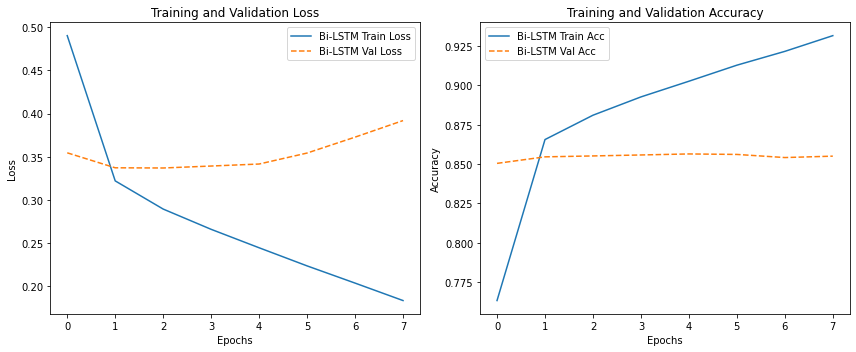

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Bi-LSTM Train Loss')
plt.plot(history.history['val_loss'], label='Bi-LSTM Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Bi-LSTM Train Acc')
plt.plot(history.history['val_accuracy'], label='Bi-LSTM Val Acc', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [65]:
vocab_size = len(word_to_index)
word_vector_dim = korean_word_vectors.wv.vectors.shape[1]

filepath = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_pretrained.txt'
write_embedding_layer(trained_model, vocab_size, word_vector_dim, index_to_word, filepath)

print(get_similar_words(filepath, "재미"))
print(get_similar_words(filepath, "실망"))

[('매우', 0.7586271166801453), ('너무', 0.749584436416626), ('그래서', 0.7295693159103394), ('이렇게', 0.7182397246360779), ('으므로', 0.6948248147964478), ('긴장감', 0.6930662989616394), ('김영철', 0.6865555644035339), ('완전', 0.6856405138969421), ('차마', 0.6853235363960266), ('당연', 0.678372323513031)]
[('쓰레기', 0.8959003686904907), ('낚였', 0.8894656896591187), ('어설픈', 0.8866159915924072), ('부실', 0.8863849639892578), ('아까움', 0.8760963082313538), ('재미없', 0.8760350346565247), ('과하', 0.8740031123161316), ('억지', 0.873901903629303), ('엉성', 0.8705606460571289), ('삼류', 0.8689274787902832)]


#### 성능 비교 
LSTM            | Loss 0.430288165807724 | Accuracy 0.84781414270401  

LSTM - Word2Vec | Loss 0.39339056611061096 | Accuracy 0.8507232069969177  
  
- 기존 LSTM 모델을 활용하여 재학습
- Loss는 0.03, Accuracy는 0.003 정도 좋아져서 85%를 아아아주 조금 넘김
- 둘 다 부정적인 단어는 잘 찾아냄

### 추가 실험 - padding 비교 pre vs post


In [66]:
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
max_len = get_max_len(X_train + X_test)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                               value=word_to_index['<PAD>'],
                                                               padding='post',
                                                               maxlen=max_len)

X_train_post, X_val_post, y_train_final, y_val = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=42
)

X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                              value=word_to_index['<PAD>'],
                                                              padding='post',
                                                              maxlen=max_len)

In [67]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    Bidirectional(LSTM(8, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [68]:
trained_model, history = train_model_history(model_bilstm,
                                             {'x': X_train_post, 'y': y_train_final},
                                             {'x': X_val_post, 'y': y_val})

results = test_model(trained_model, {'x': X_test_padded, 'y': y_test})

Epoch 1/20
229/229 [==============================] - 5s 12ms/step - loss: 0.4551 - accuracy: 0.7999 - val_loss: 0.3493 - val_accuracy: 0.8496
Epoch 2/20
229/229 [==============================] - 2s 9ms/step - loss: 0.3163 - accuracy: 0.8668 - val_loss: 0.3359 - val_accuracy: 0.8563
Epoch 3/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2849 - accuracy: 0.8812 - val_loss: 0.3347 - val_accuracy: 0.8580
Epoch 4/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2614 - accuracy: 0.8926 - val_loss: 0.3368 - val_accuracy: 0.8591
Epoch 5/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2398 - accuracy: 0.9031 - val_loss: 0.3456 - val_accuracy: 0.8582
Epoch 6/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2202 - accuracy: 0.9121 - val_loss: 0.3570 - val_accuracy: 0.8534
Epoch 7/20
229/229 [==============================] - 2s 9ms/step - loss: 0.2010 - accuracy: 0.9213 - val_loss: 0.3698 - val_accuracy: 0.8540
Epoch

### 회고
1. 모델을 구성할 때 유닛 사이즈를 크게 하고 층을 조금만 줬었는데 수렴하지 않았음
   - 유닛 사이즈를 줄이고 층을 조금 늘렸더니 좀 나아진 듯
2. 이번에는 시간이 없어서 함수화를 제대로 못 해서 아쉽..
3. 흥미로웠던 부분은 미리 학습된 임베딩 모델을 사용했을 때 '재미'의 비슷한 단어로 '비애'와 '향수'도 포함되어 있음
   ![pos_words.png](./images/pos_words.png)
4. 여러 번 돌려봤는데 돌릴 때 마다 모델이 비슷한 단어로 반환하는 것들이 달라짐
5. 패딩을 뒤에 주는 실험을 lstm이랑 bilstm 두 가지를 해봄
   - lstm은 꽤 큰 성능 차이가 있었음
   - bilstm은 비슷
     - 양방향이라 그런가.......